# Genome-scale reconstruction workflow

This notebook serves as a step-by-step workflow for improving or reconstructing metabolic models and showcasing the functionality of the MetMod library.

It is a part of a bachelor's thesis, where the theoretical aspects of metabolic model reconstruction are introduced and discussed.

## 0. Dependencies and setup

We recommend using Python 3.9 as this version's functionality has been tested.

The following libraries are required:
* cobra, escher, networkx, libsbml, matplotlib, XlsxWriter, json, pandas, numpy

Additional:
* ModelPolisher, efmtool, Cytoscape, Cplex

If there are any problems with Escher visualisation, refer to https://escher.readthedocs.io/en/latest/escher-python.html#Installation, as further Jupyter extensions may be required.

We recommend using the academic or commercial license of Cplex for optimisation; the free version will not work due to the size of metabolic models.

Run the following cell in order to install dependencies

In [ ]:
%pip install cobra escher networkx git+https://github.com/draeger-lab/MPClient.git libsbml matplotlib xlsxwriter json pandas numpy efmtool

In [ ]:
# This could also be possibly needed for Escher to run properly
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install escher

In [1]:
import cobra, escher, libsbml, os
import numpy as np
import matplotlib as plt
import networkx as nx
import metmod

In [ ]:
model_name = 'draft'

In [ ]:
# Some models created by automated tools will have some issues, like not having flux bounds set
# correctly, in order to suppress warnings run this cell
import logging

logging.getLogger('cobra').setLevel(logging.ERROR)

## 1. Draft reconstruction

A draft reconstruction is expected as input; we recommend using an automated software designed for this purpose, such as PathwayTools - PathoLogic or CarveMe.

### Standardising nomenclature

ModelPolisher is used in order to standardise and polish annotations of the draft reconstruction.

**NOTE** polishing bigger models (>1000 reactions) may take up to few minutes

In [ ]:
input_path = os.path.join('input', 'caldimonas_draft.xml')

In [ ]:
polished_path = os.path.join('models', f'{model_name}_polished.xml')

In [7]:
metmod.polish_model(input_path, polished_path, print_diff=True)

Polished SBML model successfully saved in models/draft_polished.xml


## 2. First assessment

In the section we will take a first look at the draft reconstruction. We highly encourage the use of Cytoscape for this step.

### Escher

While Escher does not provide a way to visualise the entire network, it allows for easy mapping of the model to an existing visualisation.

However, the IDs in the model must match the IDs in the map, depending on the software used for draft reconstruction **this approach may not work**.

In [6]:
# The available maps are listed by the following command.
escher.list_available_maps()

[{'organism': 'Saccharomyces cerevisiae',
  'map_name': 'iMM904.Central carbon metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Inositol retinol metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Glycolysis TCA PPP'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Tryptophan metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Carbohydrate metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Amino acid metabolism (partial)'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Nucleotide metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid biosynthesis (saturated)'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Nucleotide and histidine biosynthesis'},
 {'organism': 'Escherichia coli', 'map_name': 'e_coli_core.Core metabolism'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Central metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid beta-oxidation'}

In [7]:
map_path = os.path.join('maps', 'e_coli_core.Core metabolism.json')

Escher provides a Builder class where all setting are configured. Here we use an existing map with our model.

In [8]:
metmod.escher_build(polished_path, 'e_coli_core.Core metabolism', online_map=True, highlight_missing=True)

ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


Builder(highlight_missing=True)

Reactions highlighted in red are missing from the model; however note that this may also be the cause of using different nomenclature.

When using Pathologic, for example, there will be nomenclature differences. Therefore, the following function tries to scrape BiGG identifiers provided by ModelPolisher and change the nomenclature of an Escher map.

In [9]:
metmod.escher_map_sync(map_path, polished_path)

Updated map saved as maps/renamed_e_coli_core.Core metabolism.json


In [10]:
renamed_map = 'maps/renamed_e_coli_core.Core metabolism.json'

In [11]:
metmod.escher_build(polished_path, renamed_map, highlight_missing=True)

ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


Builder(highlight_missing=True)

Hopefully some pathways are now blue, if that is not the case manual renaming is required.

### Topology analysis

NetworkX is used for graph algorithms, some wrappers are present in MetMod.

In [12]:
model = cobra.io.read_sbml_model(polished_path)

ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


Firstly, a function that creates a directed G graph is called.

In [13]:
G = metmod.create_metabolic_graph(model)

In [ ]:
# Print out nodes sorted by node degree (+reversed)
metmod.print_degree_sorted(G)

Highest degree nodes:
[('PROTON_c', 1780), ('WATER_c', 1000), ('ATP_c', 498), ('PPI_c', 330), ('Pi_c', 306), ('ADP_c', 272), ('AMP_c', 248), ('NAD_c', 238), ('NADH_c', 230), ('NADPH_c', 206), ('NADP_c', 198), ('CO-A_c', 168), ('AMMONIUM_c', 154), ('CARBON-DIOXIDE_c', 150), ('S-ADENOSYLMETHIONINE_c', 134), ('PROTON_p', 122), ('OXYGEN-MOLECULE_c', 104), ('GLT_c', 100), ('WATER_p', 98), ('ADENOSYL-HOMO-CYS_c', 88), ('PYRUVATE_c', 84), ('ACETYL-COA_c', 78), ('ACP_c', 76), ('GLUTATHIONE_c', 60), ('L-ALPHA-ALANINE_c', 56), ('Acceptor_c', 54), ('CYS_c', 54), ('Donor-H2_c', 54), ('_2-KETOGLUTARATE_c', 52), ('MET_c', 52), ('GTP_c', 46), ('Pi_p', 44), ('GLY_c', 40), ('UDP_c', 40), ('ACET_c', 36), ('CMP_c', 36), ('GLN_c', 36), ('L-ASPARTATE_c', 36), ('UMP_c', 36), ('_2-AMINOACRYLATE_c', 34), ('FORMATE_c', 32), ('SER_c', 32), ('CH33ADO_c', 30), ('HCO3_c', 30), ('CTP_c', 28), ('FUM_c', 28), ('PHOSPHO-ENOL-PYRUVATE_c', 28), ('_5-METHYLTHIOADENOSINE_c', 26), ('AMMONIA_c', 26), ('CPD-9956_CCO-PM-BAC-N

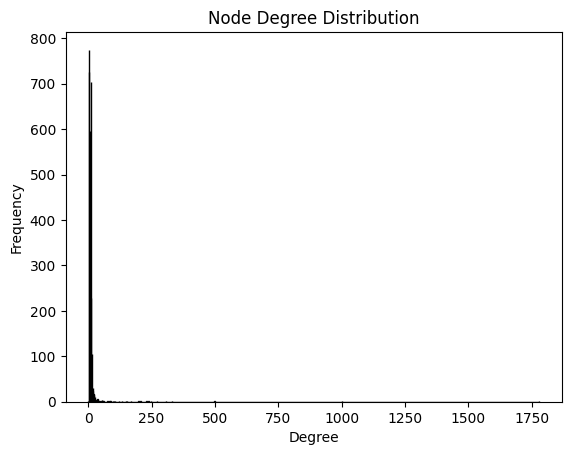

In [15]:
metmod.print_degree_distribution(G)

In [ ]:
# Single node strongly connected components are omitted
metmod.print_strongly_connected(G)

3 {'_16S-rRNA-uridine516_c', 'RXN-11833', '_16S-rRNA-pseudouridine516_c'}
3 {'TRANS-RXN-403', 'Apocytochromes-c_c', 'Apocytochromes-c_p'}
3 {'TRANS-RXN2SQN-2', 'CPD-11678_p', 'CPD-11678_c'}
3 {'CPD-8624_c', 'PEPTIDYLPROLYL-ISOMERASE-RXN[CCO-CYTOSOL]-CPD-8624//CPD-8625.32.', 'CPD-8625_c'}
3 {'PEPTIDYLPROLYL-ISOMERASE-RXN[CCO-PERI-BAC]-CPD-8624//CPD-8625.33.', 'CPD-8624_p', 'CPD-8625_p'}
3 {'CPDN-384_c', 'RXNN-386', 'CPDN-385_c'}
3 {'TRANS-RXN0-498', 'F-_p', 'F-_c'}
3 {'HOMOSERINE-LACTONE_c', 'HOMOSERINE-LACTONE_p', 'TRANS-RXN2SQN-6'}
3 {'Maltodextrins_c', '_5.4.99.15-RXN', 'MALTOOLIGOSYLTREHALOSE_c'}
3 {'TRANS-RXN-141', 'MG+2_p', 'MG+2_c'}
3 {'TRANS-RXN2SQN-8', 'PYRIMIDINE-RING_c', 'PYRIMIDINE-RING_p'}
3 {'Prolipoprotein-Cysteines_CCO-IN', 'RXN-24296', 'Prolipoprotein-Cysteines_CCO-MEMBRANE'}
3 {'tRNA-pseudouridine-38-40_c', 'TRNA-PSEUDOURIDINE-SYNTHASE-I-RXN', 'tRNA-uridine-38-40_c'}
4 {'RXN0-5190[CCO-CYTOSOL]-Nascent-peptidoglycan-dimer//GlcNAc-1-6-anhydro-MurNAc-pentapeptide/NAcMur-P

Some helper functions should make it easy to work with the graph, as naming can be unintuitive. Creation of variables instead of relying on strings is encouraged.

In [17]:
# Inspect all node names
# metmod.print_graph_nodes_names()
# Find for names containing a string
metmod.find_graph_names_with(G, 'ADP')

['_3-5-ADP_c',
 'ADP_p',
 'ADP_c',
 'ADP-D-GLUCOSE_c',
 'ADP-D-GLYCERO-D-MANNO-HEPTOSE_c',
 'DADP_c',
 'NADP_c',
 'NADPH_c',
 'Ox-NADPH-Hemoprotein-Reductases_c',
 'Red-NADPH-Hemoprotein-Reductases_c',
 '_3.4.21.92-RXN-General-Protein-Substrates/ATP/WATER//Peptides-holder/ADP/Pi/PROTON.68.',
 'RXN66-546-4-HYDROXY-L-PROLINE/NADP//PYRROLINE-HYDROXY-CARBOXYLATE/NADPH/PROTON.69.',
 '_3.4.21.53-RXN-General-Protein-Substrates/ATP/WATER//Peptides-holder/ADP/Pi/PROTON.68.',
 'RXN-8774-ARABINOSE/NADP//CPD-368/NADPH/PROTON.37.',
 'GLUTATHIONE-REDUCT-NADPH-RXN',
 'HOMOSERDEHYDROG-RXN-HOMO-SER/NADP//L-ASPARTATE-SEMIALDEHYDE/NADPH/PROTON.53.',
 'RXN66-281-CPD-465/NADPH/PROTON//SQUALENE/NADP/PPI.40.',
 'NADPH-DEHYDROGENASE-FLAVIN-RXN',
 'RXN-21299-General-Protein-Substrates/ATP/WATER//Peptides-holder/ADP/Pi/PROTON.68.',
 'GLYOXYLATE-REDUCTASE-NADP+-RXN',
 '_3-OXOACYL-ACP-REDUCT-RXN-POLYMER-INST-OH-ACYL-ACP-C8-H16/NADP//3-oxo-dodecanoyl-ACPs/NADPH/PROTON.73.',
 '_3-OXOACYL-ACP-REDUCT-RXN-POLYMER-INST

In [18]:
g6p = 'GLC-6-P_c'
r5p = 'RIBOSE-5P_c'
ru5p = 'RIBULOSE-5P_c'

In [19]:
metmod.print_neighbors(G, g6p)

GLUCOKIN-RXN-ALPHA-GLUCOSE/ATP//GLC-6-P/ADP/PROTON.38.
GLUCOKIN-RXN-GLC/ATP//GLC-6-P/ADP/PROTON.28.
GLUCOKIN-RXN-Glucopyranose/ATP//GLC-6-P/ADP/PROTON.38.
TREHALOSE6PSYN-RXN-CPD-12575/GLC-6-P//TREHALOSE-6P/UDP/PROTON.43.
PHOSPHOGLUCMUT-RXN-GLC-1-P//GLC-6-P.17.
MYO-INOSITOL-1-PHOSPHATE-SYNTHASE-RXN-GLC-6-P//1-L-MYO-INOSITOL-1-P.30.
GLUCOSE-6-PHOSPHATE-1-EPIMERASE-RXN
RXN-16998-ALPHA-GLUCOSE-16-BISPHOSPHATE/Phosphoglucomutase//GLC-6-P/Phosphorylated-phosphoglucomutase.92.
GLU6PDEHYDROG-RXN-GLC-6-P/NADP//D-6-P-GLUCONO-DELTA-LACTONE/NADPH/PROTON.55.
RXN-761-ADP-D-GLUCOSE/GLC-6-P//TREHALOSE-6P/ADP/PROTON.47.


In [20]:
_, named = metmod.find_paths(G, g6p, r5p, [], 10, print_path=True)

['beta-D-glucose 6-phosphate', 'GLUCOKIN-RXN-ALPHA-GLUCOSE/ATP//GLC-6-P/ADP/PROTON.38.', 'ATP', 'Phosphoribosylpyrophosphate synthetase', 'D-ribose 5-phosphate']
['beta-D-glucose 6-phosphate', 'GLUCOKIN-RXN-GLC/ATP//GLC-6-P/ADP/PROTON.28.', 'H+', 'Phosphoribosylpyrophosphate synthetase', 'D-ribose 5-phosphate']
['beta-D-glucose 6-phosphate', 'GLUCOKIN-RXN-ALPHA-GLUCOSE/ATP//GLC-6-P/ADP/PROTON.38.', 'H+', 'Phosphoribosylpyrophosphate synthetase', 'D-ribose 5-phosphate']
['beta-D-glucose 6-phosphate', 'GLUCOKIN-RXN-Glucopyranose/ATP//GLC-6-P/ADP/PROTON.38.', 'H+', 'Phosphoribosylpyrophosphate synthetase', 'D-ribose 5-phosphate']
['beta-D-glucose 6-phosphate', 'GLUCOKIN-RXN-GLC/ATP//GLC-6-P/ADP/PROTON.28.', 'ATP', 'Phosphoribosylpyrophosphate synthetase', 'D-ribose 5-phosphate']
['beta-D-glucose 6-phosphate', 'TREHALOSE6PSYN-RXN-CPD-12575/GLC-6-P//TREHALOSE-6P/UDP/PROTON.43.', 'H+', 'Phosphoribosylpyrophosphate synthetase', 'D-ribose 5-phosphate']
['beta-D-glucose 6-phosphate', 'GLUCOKIN-

In [21]:
print(metmod.get_id_by_name(G, 'ADP'))

ADP_p


In [22]:
# Threshold needs to be tinkered with and set based on degree distribution
# Check if any important nodes were deleted
pruned_G = metmod.prune_graph(G, 500, [])

# Manually delete some nodes
pruned_G = metmod.delete_nodes_by_id(pruned_G, ['GLUCOKIN-RXN-ALPHA-GLUCOSE/ATP//GLC-6-P/ADP/PROTON.38.', 'ADP_c'])

# Only 6 paths were chosen to speed up the execution
_, named = metmod.find_paths(pruned_G, g6p, r5p, [ru5p], 6, print_path=True)

Removed 87 nodes with degree greater than 500.
Removed the following nodes: ['UDP-MurNAc-L-Ala-gamma-D-Glu-meso-DAP-D-Ala-D-Ala', 'UDP-N-acetyl-alpha-D-muramoyl-L-alanyl-gamma-D-glutamyl-L-lysyl-D-alanyl-D-alanine', 'UDP-N-acetyl-alpha-D-muramoyl-L-alanyl-gamma-D-glutamyl-L-lysyl-D-alanine', 'UDP-alpha-D-glucose', 'UDP-2-acetamido-2,6-dideoxy-alpha-D-xylo-hex-4-ulose', 'UDP-alpha-D-galactose', 'UDP-N-acetyl-alpha-D-galactosamine', 'UDP-N-acetyl-alpha-D-muramoyl-L-alanyl-gamma-D-glutamyl-L-lysine', 'UDP-2-N-[(3R)-3-hydroxydodecanoyl]-3-O-[(3R)-3-hydroxydecanoyl]-alpha-D-glucosamine', 'UDP-3-O-[(3R)-3-hydroxydecanoyl]-alpha-D-glucosamine', 'UDP-3-O-[(3R)-3-hydroxydecanoyl]-N-acetyl-alpha-D-glucosamine', 'UDP-2-N-[(3R)-3-hydroxy-16-methylhexadecanoyl]-3-O-[(3R)-3-hydroxyhexadecanoyl]-alpha-D-glucosamine', 'UDP-2-N-[(3R)-3-hydroxy-15-methylhexadecanoyl]-3-O-[(3R)-3-hydroxy-13-methyltetradecanoyl]-alpha-D-glucosamine', 'UDP-3-O-[(3R)-3-hydroxy-13-methyltetradecanoyl]-alpha-D-glucosamine', '

## 3. Iterative workflow

### 3.1 Refinement

Firstly we will create additional files in order to ease manual refinement of model.

In [ ]:
xlsx_path = os.path.join('models', f'{model_name}.xlsx')

In [24]:
model = cobra.io.read_sbml_model(polished_path)
# Create a xlsx file from cobra model
metmod.cobra_to_xlsx(model, xlsx_path)

ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


Model saved to models/draft.xlsx


In [ ]:
# Sync xlsx file with SBML and json
metmod.sync_xlsx(xlsx_path, model_name)
# There are some metabolite formula information missing,
# while testing this function did not work due to problems in the model

unknown metabolite 'NA' created
unknown metabolite '_CCO-IN' created
unknown metabolite '_CCO-OUT' created
unknown metabolite '_c' created
unknown metabolite '_p' created
unknown metabolite 'K' created
unknown metabolite 'FE' created
unknown metabolite '2_c' created
unknown metabolite '3_c' created
unknown metabolite '2_p' created
unknown metabolite '3_p' created
unknown metabolite 'MG' created
unknown metabolite 'CD' created
unknown metabolite '2_e' created


TypeError: in method 'FbcSpeciesPlugin_setChemicalFormula', argument 2 of type 'std::string const &'

In [ ]:
# Optionally load a cobra model from xlsx
model = metmod.xlsx_to_cobra(xlsx_path, model_name)

Additionally, for working with Escher maps and creating a core model, a function which deletes all compounds not present in a map is available. 

In [ ]:
metmod.mini_model_prune(map_path, polished_path, f'mini_{model_name}')
mini_model_path = f'mini_{model_name}.xml'

ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized
/opt/miniconda3/envs/bio/lib/python3.9/site-packages/cobra/core/group.py:147: UserWarning: need to pass in a list
  warn("need to pass in a list")


Model saved to models/mini_draft.xlsx
Filtered model saved as models/mini_draft
Removed 1749 reactions.
Removed 1897 metabolites.


### 3.2 Cross checking

#### Flux Balance Analysis

Make sure the model has an objective function.

In [26]:
print(model.objective)          # Shows the symbolic expression
print(model.objective.expression)  # Explicit formula (reaction * coefficient)
print(model.objective.direction)   # 'max' or 'min'

Maximize
0
0
max


In [ ]:
# If the model contains a biomass reaction, it can be set as objective:
biomass = model.reactions.get_by_id('Biomass')
model.objective = biomass

KeyError: 'Biomass'

A quick way to test a biomass function may be to use an existing one from a different model, metmod.filter_reaction deletes all metabolites in the reaction that are not found in the model.

In [29]:
ecoli_biomass_core = """
1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c +
4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c + 0.5191 pep_c + 2.8328 pyr_c + 0.8977 r5p_c 
→ 59.81 adp_c + 4.1182 akg_c + 3.7478 coa_c + 59.81 h_c + 3.547 nadh_c + 13.0279 nadp_c + 59.81 pi_c
"""
# metmod.filter_reaction(ecoli_biomass_core, model, arrow_symbol="→")
# filter_reaction_bigg additionally renames metabolites in the formula to match metabolites in the model, uses ModelPoliher BiGG annotation
reaction = metmod.filter_reaction_bigg(ecoli_biomass_core, polished_path, arrow_symbol="→")
print(reaction)

ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


1.496 G3P_c + 59.81 ATP_c + 0.129 GAP_c + 0.2557 GLN_c + 4.9414 GLT_c + 3.547 NAD_c + 13.0279 NADPH_c + 1.7867 OXALACETIC_ACID_c + 2.8328 PYRUVATE_c --> 59.81 ADP_c + 59.81 PROTON_p + 3.547 NADH_c + 13.0279 NADP_c + 59.81 Pi_c


In [30]:
# With formula string, we can add the objective function
metmod.add_objective_function(reaction, model)

In [31]:
solution = model.optimize()
solution

,fluxes,reduced_costs
_2.7.9.3-RXN,0.0,0.000000e+00
RXN-19546,0.0,-0.000000e+00
RXN-24044,0.0,-0.000000e+00
RXN-16690[CCO-PERI-BAC]-CPD-17947//CPD-17988/UNDECAPRENYL-DIPHOSPHATE/PROTON.67.,0.0,0.000000e+00
RXN-16690[CCO-CYTOSOL]-CPD-17947//CPD-17988/UNDECAPRENYL-DIPHOSPHATE/PROTON.66.,0.0,-0.000000e+00
...,...,...
PRTRANS-RXN,0.0,-2.081668e-17
RXN0-5462[CCO-PERI-BAC]-GTP/WATER//GDP/Pi/PROTON.39.,0.0,-0.000000e+00
RXN0-5462[CCO-CYTOSOL]-GTP/WATER//GDP/Pi/PROTON.38.,0.0,0.000000e+00
RXN-20150,0.0,0.000000e+00


Run and visualise FBA in Escher

In [32]:
metmod.escher_build(polished_path, renamed_map, reaction_data=model.optimize().fluxes)

ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


Builder(highlight_missing=False, reaction_data={'_2.7.9.3-RXN': 0.0, 'RXN-19546': 0.0, 'RXN-24044': 0.0, 'RXN-…

Knockout a gene.

In [33]:
print(model.genes)

[<Gene IS481_06190 at 0x30c34e820>, <Gene IS481_09910 at 0x30c34e940>, <Gene IS481_03845 at 0x30c34e910>, <Gene IS481_09920 at 0x30c34ea60>, <Gene IS481_04650 at 0x30c34e9a0>, <Gene IS481_04630 at 0x30c34e790>, <Gene IS481_16015 at 0x30c34e850>, <Gene IS481_09475 at 0x30c34e7f0>, <Gene IS481_05615 at 0x30c34e970>, <Gene IS481_14135 at 0x30c34e8b0>, <Gene IS481_14640 at 0x30c34ea00>, <Gene IS481_16490 at 0x30c34eac0>, <Gene IS481_17250 at 0x30c34eb20>, <Gene IS481_04855 at 0x30c34e9d0>, <Gene IS481_09360 at 0x30c34eb80>, <Gene IS481_03030 at 0x30c34ea30>, <Gene IS481_14465 at 0x30c34ebe0>, <Gene IS481_02320 at 0x30c34ea90>, <Gene IS481_03070 at 0x30c34ec40>, <Gene IS481_11575 at 0x30c34eaf0>, <Gene IS481_06225 at 0x30c34eca0>, <Gene IS481_03855 at 0x30c34eb50>, <Gene IS481_01130 at 0x30c34ed00>, <Gene IS481_01105 at 0x30c34ebb0>, <Gene IS481_10670 at 0x30c34ed60>, <Gene IS481_11170 at 0x30c34ec10>, <Gene IS481_00230 at 0x30c34edc0>, <Gene IS481_17680 at 0x30c34ec70>, <Gene IS481_03950 a

In [34]:
model.genes.IS481_03595.knock_out()

In [36]:
metmod.escher_build(polished_path, renamed_map, reaction_data=model.optimize().fluxes)

ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


Builder(highlight_missing=False, reaction_data={'_2.7.9.3-RXN': 0.0, 'RXN-19546': 0.0, 'RXN-24044': 0.0, 'RXN-…

#### Elementary Flux Mode analysis
* Note that efmtool requires Java 8; one way of switching Java versions is as follows: export JAVA_HOME=$(/usr/libexec/java_home -v 1.8)

*Since enumerating EFMs is complex, we will not use it on the draft model.*

In [ ]:
# model = cobra.io.read_sbml_model(polished_path)

ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


If the cell is taking a long time to run, try turning the logger on to see if there is an issue.

In [ ]:
# efm_matrix = metmod.calculate_efm_matrix(model, log=True)

In [ ]:
# smallest_efm_idx = metmod.find_smallest_efm(efm_matrix)
# smallest_efm = efm_matrix[:, smallest_efm_idx]

In [ ]:
# all_efms = metmod.combine_all_efms(efm_matrix)

In [ ]:
# print(metmod.find_reaction_not_in_efms(efm_matrix, model))

We can again visualise data with Escher; efm_for_escher returns reaction data. Alternatively, reaction data can be saved to a file.

In [ ]:
# metmod.escher_build(polished_path, "renamed_e_coli_core.Core metabolism.json", reaction_data=metmod.efm_for_escher(model, all_efms))

Check how many EFMs contain a specific reaction. Reaction ID is used.

In [ ]:
# efms_with_biomass = metmod.filter_efms(efm_matrix, ["BIOMASS_Ecoli_core_w_GAM"], model)
# len(efms_with_biomass)

#### Gene expression data

In [ ]:
gene_expression_data = metmod.filter_gene_csv(os.path.join('expression_data', 'RNASeq2_RAW_CountTable.csv'), 1, 5, os.path.join('expression_data', 'filtered_draft_genes.csv'), delim=';')

Filtered CSV saved as expression_data/filtered_draft_genes.csv


In [ ]:
metmod.sync_map_genes(polished_path, renamed_map, 'draft_gene_map.json')

Gene rules updated and saved to maps/draft_gene_map.json


Mapping transcriptomics data to a map.

In [39]:
metmod.escher_build(polished_path, os.path.join('maps', 'draft_gene_map.json'), gene_data=gene_expression_data,)

ERROR:cobra.io.sbml:No objective coefficients in model. Unclear what should be optimized


Builder(gene_data=[{'IS481_00005': 5078.17, 'IS481_00010': 2682.0, 'IS481_00015': 7094.0, 'IS481_00020': 112.0…